# Crowded Fields

In [1]:
# Import Packages and setup
import logging
import os

import numpy as np

import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

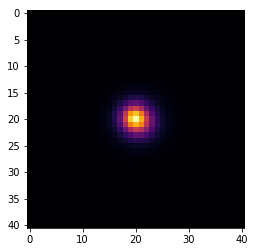

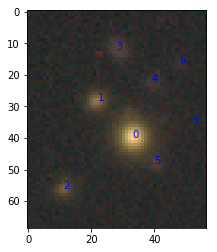

In [41]:
idx = 0
# Load a real HSC-Cosmos blend with a different PSF in each band
datapath = '../data/real_data/hsc_cosmos'
files = os.listdir(datapath)
data = np.load(os.path.join(datapath, files[idx]))
images = data["images"]
psfs = data["psfs"]
peaks = data["peaks"]
weights = data["weights"]

# Estimate the background RMS
bg_rms = np.sqrt(np.std(images, axis=(1,2))**2 + np.median(images, axis=(1,2))**2)/2

# display psfs
plt.imshow(psfs[0])
plt.show()

# Use Asinh scaling for the images
norm = scarlet.display.Asinh(img=images, Q=20)
# Map i,r,g -> RGB
filter_indices = [3,2,1]
# Convert the image to an RGB image
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=filter_indices, norm=norm)
plt.imshow(img_rgb)
for n, src in enumerate(peaks):
    plt.text(src[0], src[1], str(n), color="b")
plt.show()

In [3]:
%%time
# Fit the psfs
target_psf = scarlet.psf_match.fit_target_psf(psfs, scarlet.psf_match.moffat)
#plt.imshow(target_psf,norm=scarlet.display.Asinh(img=target_psf))
#plt.show()
diff_kernels, psf_blend = scarlet.psf_match.build_diff_kernels(psfs, target_psf)

CPU times: user 4.17 s, sys: 35.2 ms, total: 4.2 s
Wall time: 2.77 s


In [29]:
from scarlet.constraint import Normalization
config = scarlet.config.Config(update_order=[0,1], accelerated=False, refine_skip=10, update_model=True)
sources = [
    scarlet.ExtendedSource((src[1],src[0]), images, bg_rms, config=config,
                           #psf=diff_kernels,
                           normalization=Normalization.A)
    for src in peaks
]

blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms, config=config)

In [30]:
%%time
blend.fit(200, e_rel=1e-3)

CPU times: user 4.93 s, sys: 36.1 ms, total: 4.97 s
Wall time: 1.25 s


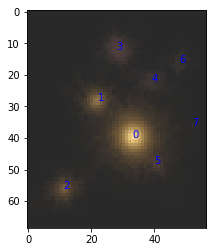

Iterations: 200
1356.759930891458


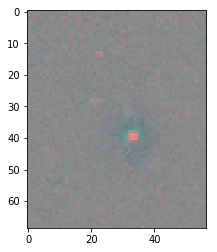

In [31]:
model = blend.get_model()
norm = scarlet.display.Asinh(img=images, Q=20)
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=norm)
plt.imshow(img_rgb)
for n, src in enumerate(peaks):
    plt.text(src[0], src[1], str(n), color="b")
plt.show()
print("Iterations:", blend.it)
residual = images-model
img_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)
plt.imshow(img_rgb)
print(np.sum(np.abs(residual)))

In [37]:
from scarlet.constraint import Normalization
config = scarlet.config.Config(update_order=[0,1], accelerated=False, refine_skip=2, update_model=True)
sources = [
    scarlet.ExtendedSource((src[1],src[0]), images, bg_rms, config=config,
                           #psf=diff_kernels,
                           normalization=Normalization.S)
    for src in peaks
]

blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms, config=config)

In [38]:
%%time
blend.fit(200, e_rel=1e-3)

CPU times: user 4.57 s, sys: 86.2 ms, total: 4.66 s
Wall time: 1.17 s


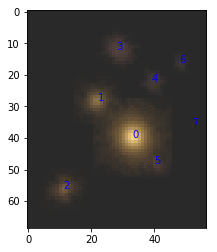

Iterations: 136
1395.9860371569252


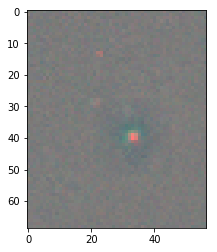

In [39]:
model = blend.get_model()
norm = scarlet.display.Asinh(img=images, Q=20)
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=norm)
plt.imshow(img_rgb)
for n, src in enumerate(peaks):
    plt.text(src[0], src[1], str(n), color="b")
plt.show()
print("Iterations:", blend.it)
residual = images-model
img_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)
plt.imshow(img_rgb)
print(np.sum(np.abs(residual)))

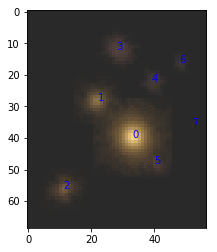

Iterations: 136
1395.9860371569252


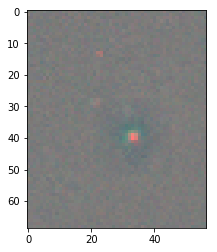

In [27]:
from scarlet.constraint import Normalization
config = scarlet.config.Config(update_order=[0,1], accelerated=False, refine_skip=2, update_model=True)
sources = [
    scarlet.ExtendedSource((src[1],src[0]), images, bg_rms, config=config, normalization=Normalization.S)
    #scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms, psf=diff_kernels, config=config)
    for src in peaks
]

blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms, config=config)
blend.fit(200, e_rel=1e-3)

model = blend.get_model()
norm = scarlet.display.Asinh(img=images, Q=20)
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=norm)
plt.imshow(img_rgb)
for n, src in enumerate(peaks):
    plt.text(src[0], src[1], str(n), color="b")
plt.show()
print("Iterations:", blend.it)
residual = images-model
img_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)
plt.imshow(img_rgb)
print(np.sum(np.abs(residual)))

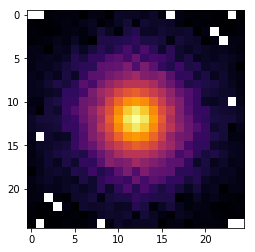

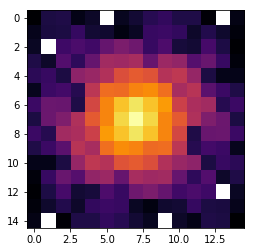

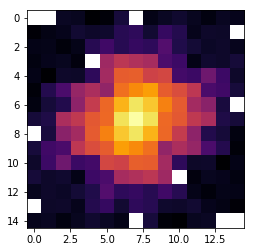

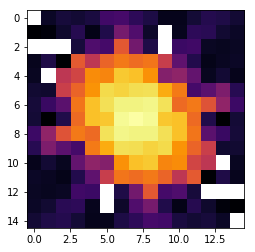

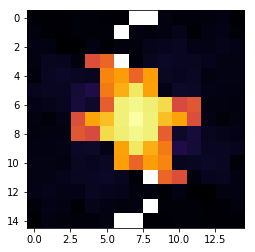

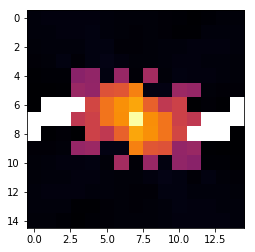

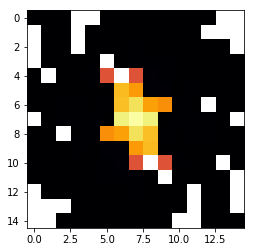

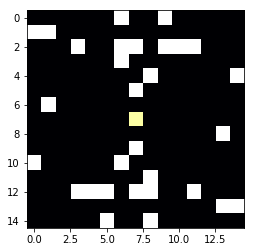

In [28]:
for src in blend.sources:
    morph = src.components[0].morph
    morph = np.ma.array(morph, mask=morph==0)
    norm = scarlet.display.Asinh(img=morph, Q=20)
    plt.imshow(morph, norm=norm)
    plt.show()

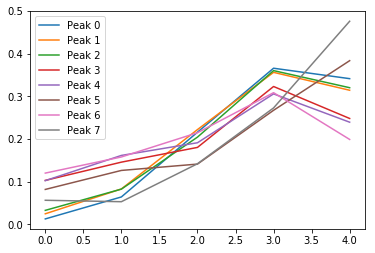

In [29]:
colors = np.array([src.components[0].sed for src in blend.sources])
cnorm = np.sum(colors, axis=1)
seds = colors/cnorm[:, None]
for n,sed in enumerate(seds):
    plt.plot(sed, label="Peak {0}".format(n))
    plt.legend()
    plt.plot()

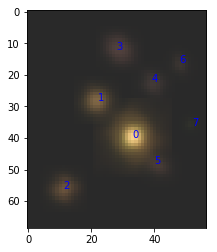

Iterations: 166


In [31]:
config = scarlet.config.Config(update_order=[0,1], accelerated=False, refine_skip=2, update_model=True)
sources = [
    scarlet.ExtendedSource((src[1],src[0]), images, bg_rms, psf=diff_kernels,
                           config=config, normalization=Normalization.S,)
    for src in peaks
]


blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms, config=config)
blend.fit(200, e_rel=1e-3)

model = blend.get_model()
norm = scarlet.display.Asinh(img=images, Q=20)
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=[3,2,1], norm=norm)
plt.imshow(img_rgb)
for n, src in enumerate(peaks):
    plt.text(src[0], src[1], str(n), color="b")
plt.show()
print("Iterations:", blend.it)
residual = images-model

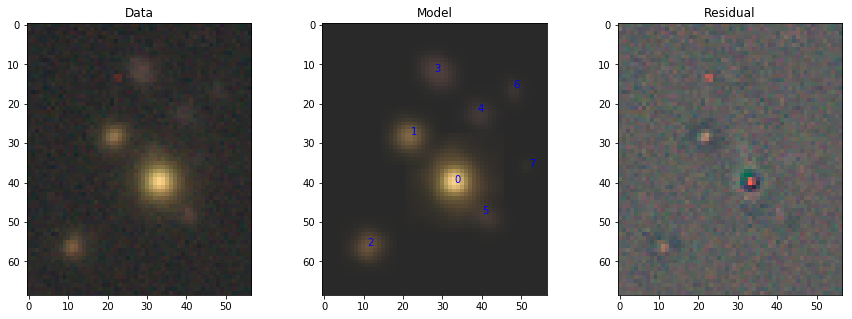

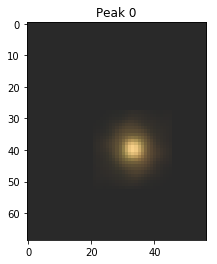

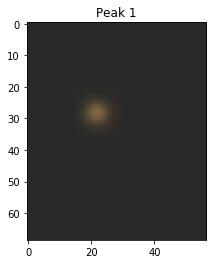

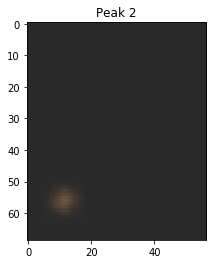

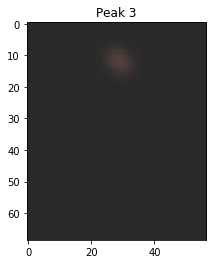

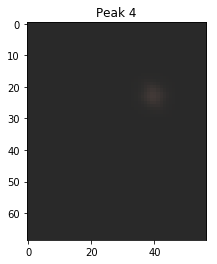

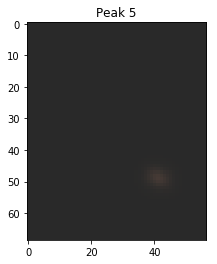

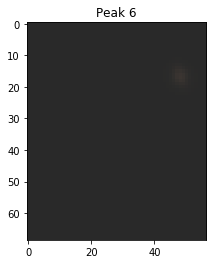

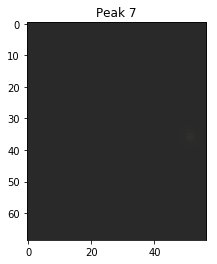

In [33]:
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
norm = scarlet.display.Asinh(img=images, Q=20)
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=filter_indices, norm=norm)
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
img_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
ax[1].imshow(img_rgb)
ax[1].set_title("Model")
img_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)
for n, src in enumerate(peaks):
    ax[1].text(src[0], src[1], str(n), color="b")
ax[2].imshow(img_rgb)
ax[2].set_title("Residual")
plt.show()

for n,src in enumerate(blend.sources):
    smodel = blend.get_model(k=n)
    img_rgb = scarlet.display.img_to_rgb(smodel, filter_indices=filter_indices, norm=norm)
    plt.imshow(img_rgb)
    plt.title("Peak {0}".format(n))
    plt.show()